In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
print(tf.__version__)

2.20.0


In [3]:
batch_size = 32
img_height = 256
img_width = 256

directory = os.path.join(os.getcwd(),"data", "training")

In [4]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for training and validation
    subset = "training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for testing results
    subset = "validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 15244 files belonging to 9 classes.
Using 12196 files for training.
Found 15244 files belonging to 9 classes.
Using 3048 files for validation.


In [5]:
class_names = training_ds.class_names
print(f"Categories: {class_names}")

Categories: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes']


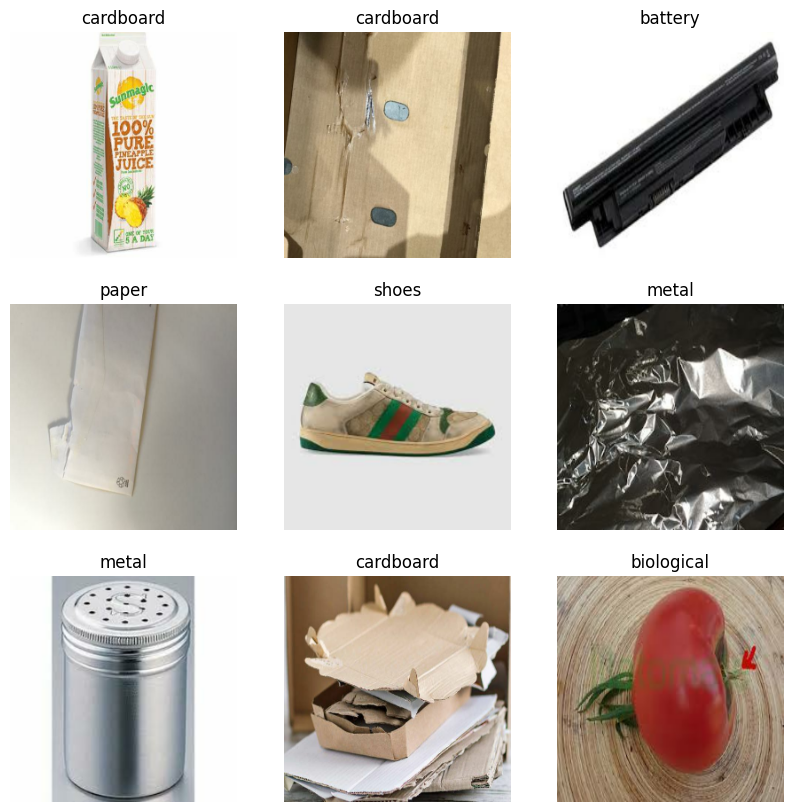

In [6]:
plt.figure(figsize=(10,10))

for images, labels in training_ds.take(1): #takes one batch of 32
    for i in range(9): 
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [7]:
#without augmentation the model was overfitting even getting worse on 
# validation data with loss doubling from epoch 3 to epoch 10

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(256,256,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

c:\Users\Cemil\CodingProjects\Sorti\.venv\lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


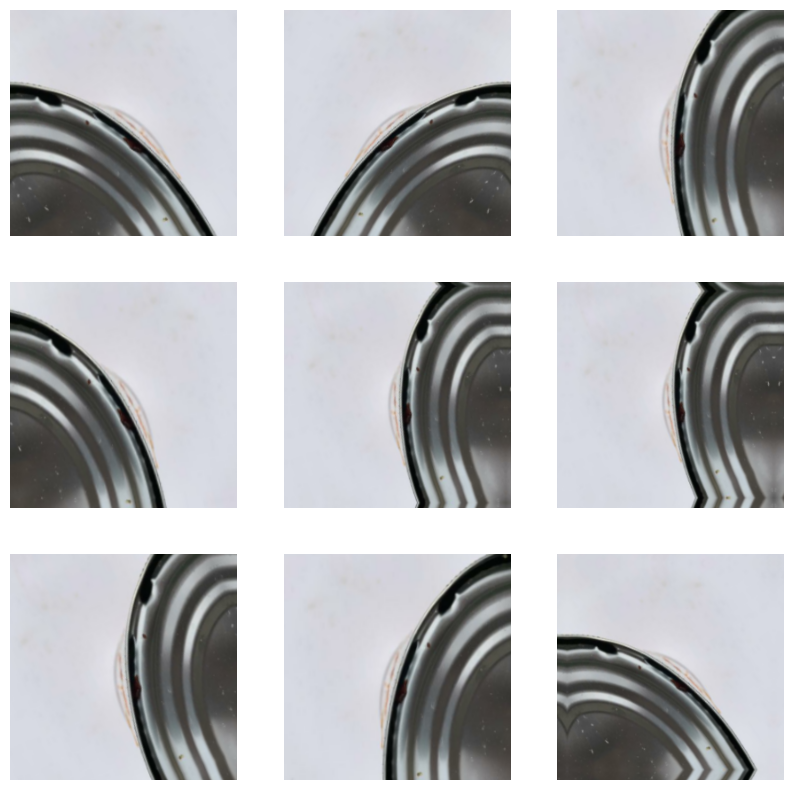

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # Show 9 variations of same img
        plt.axis("off")
plt.show()

In [9]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    #layer0 makes training harder by using augmentation
    data_augmentation,

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,413,481 (32.09 MB)

 Trainable params: 8,413,481 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

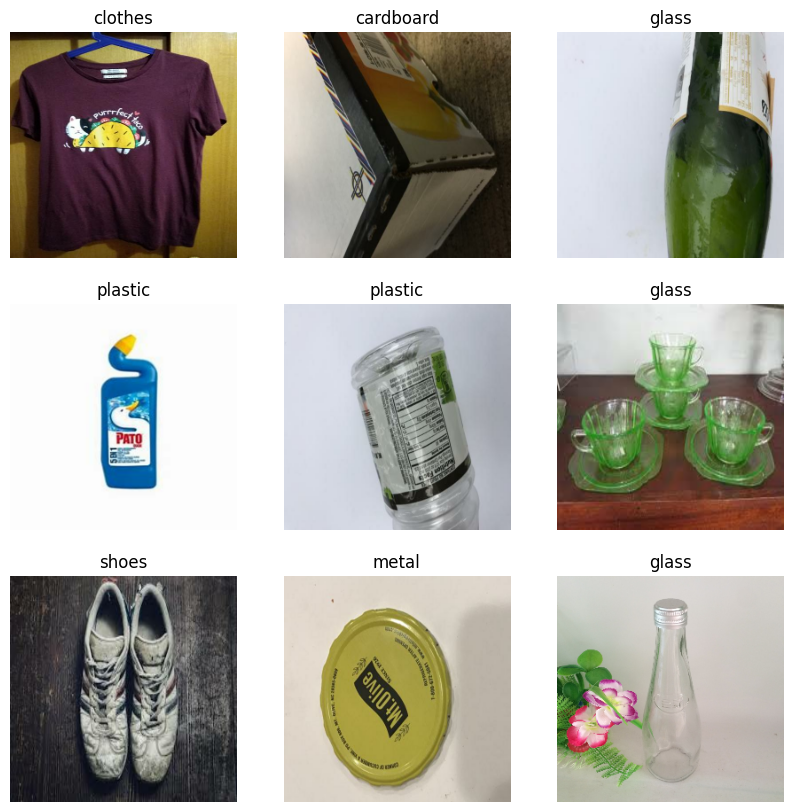

In [10]:
plt.figure(figsize=(10,10))

for images, labels in training_ds.take(1): #takes one batch of 32
    for i in range(9): 
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [11]:
#without augmentation the model was overfitting even getting worse on 
# validation data with loss doubling from epoch 3 to epoch 10

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(256,256,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

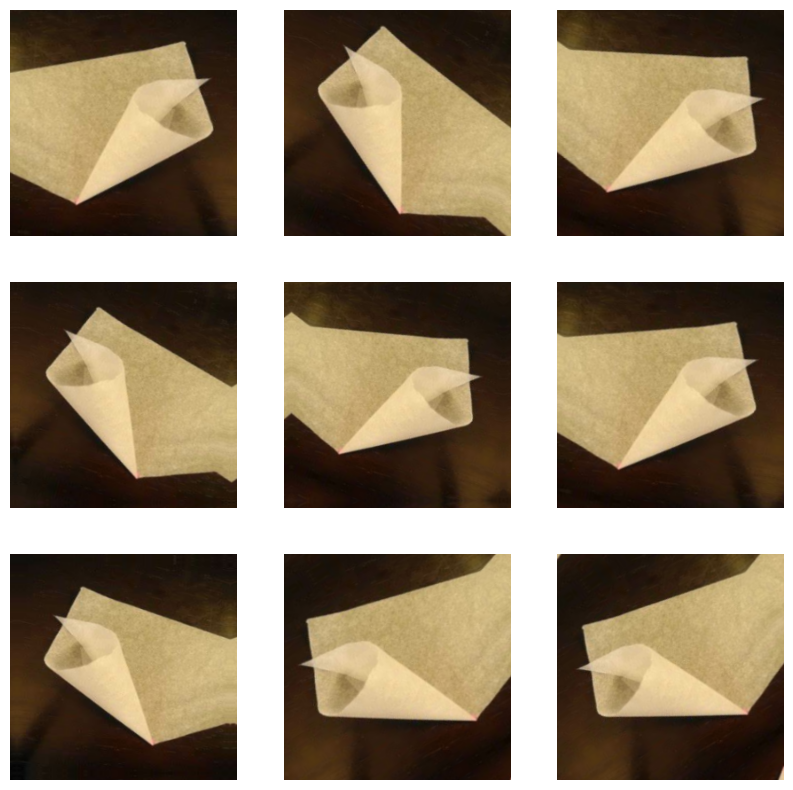

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # Show 9 variations of same img
        plt.axis("off")
plt.show()

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    #layer0 makes training harder by using augmentation
    data_augmentation,

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),

    #dropout cut 50% of connections to stop Dense Layer from Memorizing specific outputs of Conv Layers
    tf.keras.layers.Dropout(0.5),

    #layer 8: outputs 8 numbers (highest number is models guess)
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,413,481 (32.09 MB)

 Trainable params: 8,413,481 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#adam is teacher that adjusts weights and biases, loss is grading scale for accuracy
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

In [15]:
epochs = 10

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 149s 383ms/step - accuracy: 0.3548 - loss: 1.7892 - val_accuracy: 0.4984 - val_loss: 1.4342
Epoch 2/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 147s 386ms/step - accuracy: 0.5255 - loss: 1.3507 - val_accuracy: 0.5423 - val_loss: 1.3088
Epoch 3/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 166s 435ms/step - accuracy: 0.5797 - loss: 1.2137 - val_accuracy: 0.5709 - val_loss: 1.3001
Epoch 4/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 148s 387ms/step - accuracy: 0.6114 - loss: 1.1288 - val_accuracy: 0.6401 - val_loss: 1.0954
Epoch 5/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 142s 372ms/step - accuracy: 0.6378 - loss: 1.0598 - val_accuracy: 0.5686 - val_loss: 1.3066
Epoch 6/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 146s 381ms/step - accuracy: 0.6556 - loss: 0.9970 - val_accuracy: 0.6470 - val_loss: 1.1348
Epoch 7/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 149s 391ms/step - accuracy: 0.6826 - loss: 0.9283 - val_accuracy: 0.6591 - val_loss: 1.0594
Epoch 8/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 148s 388ms/step - accuracy: 0.6974 -

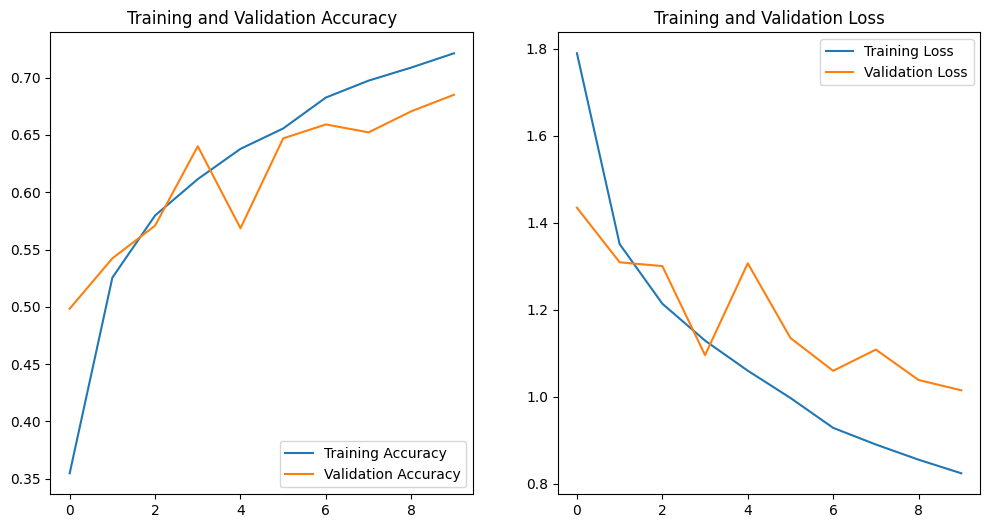

In [16]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')

plt.title('Training and Validation Loss')

plt.show()